In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy as sc
from tqdm import tnrange, tqdm_notebook
import matplotlib.backends.backend_pdf
from IPython.display import clear_output

import scvelo as scv
scv.settings.set_figure_params('scvelo', dpi_save=200, dpi=40, transparent=True)
scv.settings.verbosity = 0
sc.settings.verbosity=0

/fast/users/peidlis_c/work/miniconda/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
data_path='/fast/scratch/users/peidlis_c/sodar_patient_organoid_data/'
signatures_path='/fast/work/users/peidlis_c/projects/sodar_patient_organoid_data/signatures/'

In [172]:
from scipy import stats
for donor in ['NCO', 'p009ot', 'p013ot']:
    for letter in ['E', 'W']:
        adata = scv.read(data_path+'NB_AS_'+letter+'/processed/NB_AS_'+letter+'_'+donor+'SLAMvelo.h5')
        scv.tl.recover_latent_time(adata)
        x = adata.obs['latent_time']
        rank = np.empty((3, adata.n_vars))
        for i in range(adata.n_vars):
            y = adata.layers['Ms'][:,i]
            rank[0, i] = stats.spearmanr(x,y)[0]
            rank[1, i] = stats.pearsonr(x,y)[0]
            rank[2, i] = adata.var.fit_likelihood[i]
        rank[pd.isna(rank)]=0
        df = pd.DataFrame(rank.T, index=adata.var_names, columns=['spearmanr', 'pearsonr', 'likelihood'])
        df = df.sort_values(by=['spearmanr'], ascending=False)
        # df.to_csv('./exports/NB_AS_'+donor+letter+'_correlation_with_latenttime.csv')

[False False False ... False False False]
[  65  932   35 ... 1368  907  148]
[False False False ... False False False]
[1772   46 1800 ... 1594 1639 1761]
[False False False ... False False False]
[ 501  488  900 ...  977 1258  518]
[False False False ... False False False]
[1530 1078 1511 ... 2781 2851 2435]


Text(0.5, 1.0, '0.9640328612731748')

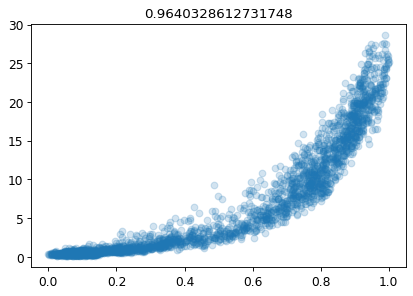

In [152]:
# sanity check
x = adata.obs['latent_time']
y = adata.layers['Ms'][:, np.argmax(rank[0,:])]
pl.scatter(x,y, alpha=0.2)
pl.title(str(max(rank[0,:])))

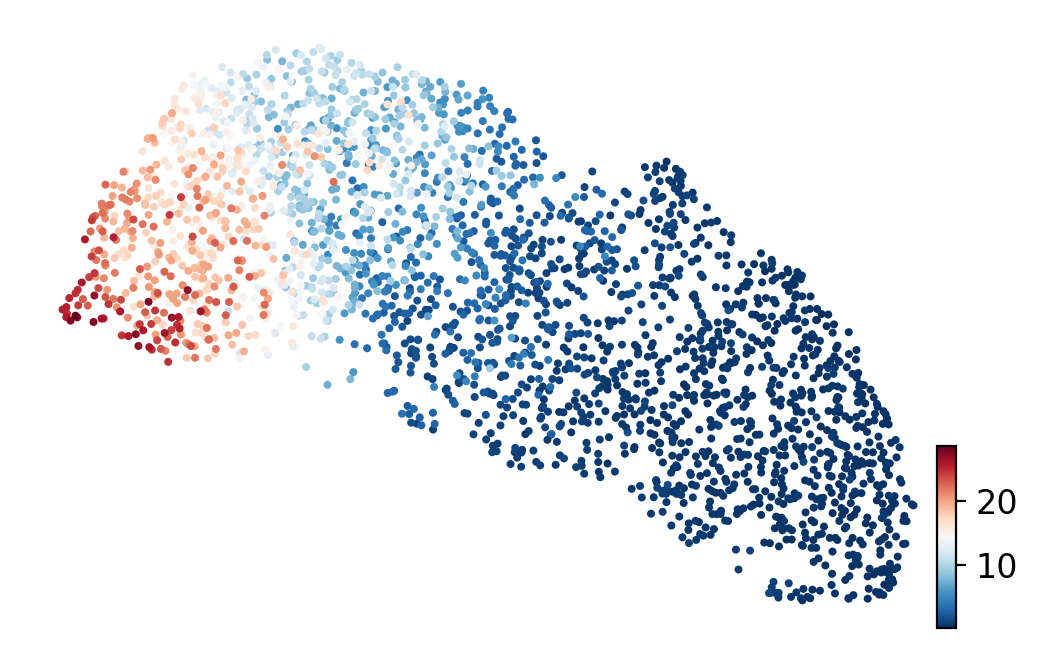

In [133]:
scv.pl.scatter(adata, color=adata.layers['Ms'][:, np.argmax(rank)], dpi=100)

In [5]:
donor='NCO'
letter='E'
df = pd.read_csv('./exports/NB_AS_'+donor+letter+'_correlation_with_latenttime.csv', index_col=0)
df.head()

,spearmanr,pearsonr,likelihood
CDKN2B-AS1,0.537433,0.616930,0.509947
ABCG2,0.519099,0.649792,0.155815
SLC6A19,0.516006,0.599391,0.150926
TMIGD1,0.510741,0.603265,0.333763
CREB3L3,0.501737,0.509064,0.000000


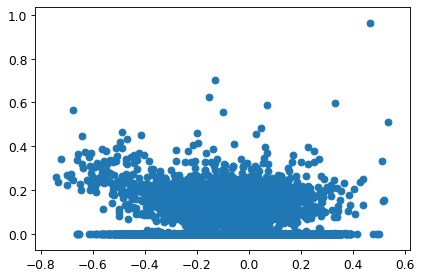

In [6]:
pl.scatter(df.spearmanr, df.likelihood)

In [7]:
mask=[d[0:2]!='RP' and d[0:3]!='MT-' for d in df.index]
dff = df[mask]

In [8]:
df_ = dff[np.abs(dff.spearmanr)>0.4]

In [9]:
var_names=list(df_.index[:50])+list(df_.index[-50:])

# intersections

In [43]:
from scvelo.plotting.utils import savefig_or_show
def heatmap(adata, var_names, tkey='pseudotime', xkey='Ms', color_map='viridis', col_color=None, n_convolve=30,
            standard_scale=0, sort=True, colorbar=None, col_cluster=False, row_cluster=False,
            figsize=(10, 5), show=True, save=None, ax=None, title=None, maxis=None, vmin=None, vmax=None):

    import seaborn as sns
    var_names = [name for name in var_names if name in adata.var_names]

    time = adata.obs[tkey].values
    time = time[np.isfinite(time)]
    data =adata[:, var_names].layers[xkey]
    
    if maxis is not None:
        data = np.divide(data, maxis)
    df = pd.DataFrame(data[np.argsort(time)], columns=var_names)

    if n_convolve is not None:
        weights = np.ones(n_convolve) / n_convolve
        for i, gene in enumerate(var_names):
            df[gene] = np.convolve(df[gene].values, weights, mode='same')

    if sort:
        max_sort = np.argsort(np.argmax(df.values, axis=0))
        df = pd.DataFrame(df.values[:, max_sort], columns=df.columns[max_sort])
    if col_color is not None: col_color = interpret_colorkey(adata, col_color)[np.argsort(time)]
    cm = sns.clustermap(df.T, col_colors=col_color, col_cluster=col_cluster, row_cluster=row_cluster, cmap=color_map, yticklabels=True,
                        xticklabels=False, standard_scale=standard_scale, figsize=figsize, vmin=vmin, vmax=vmax)
    cm.ax_heatmap.set_title(title)
    if not colorbar: cm.cax.set_visible(False)
    savefig_or_show('heatmap', save=save, show=show)
    if not show: return ax
    pl.show()
    return df.columns

...


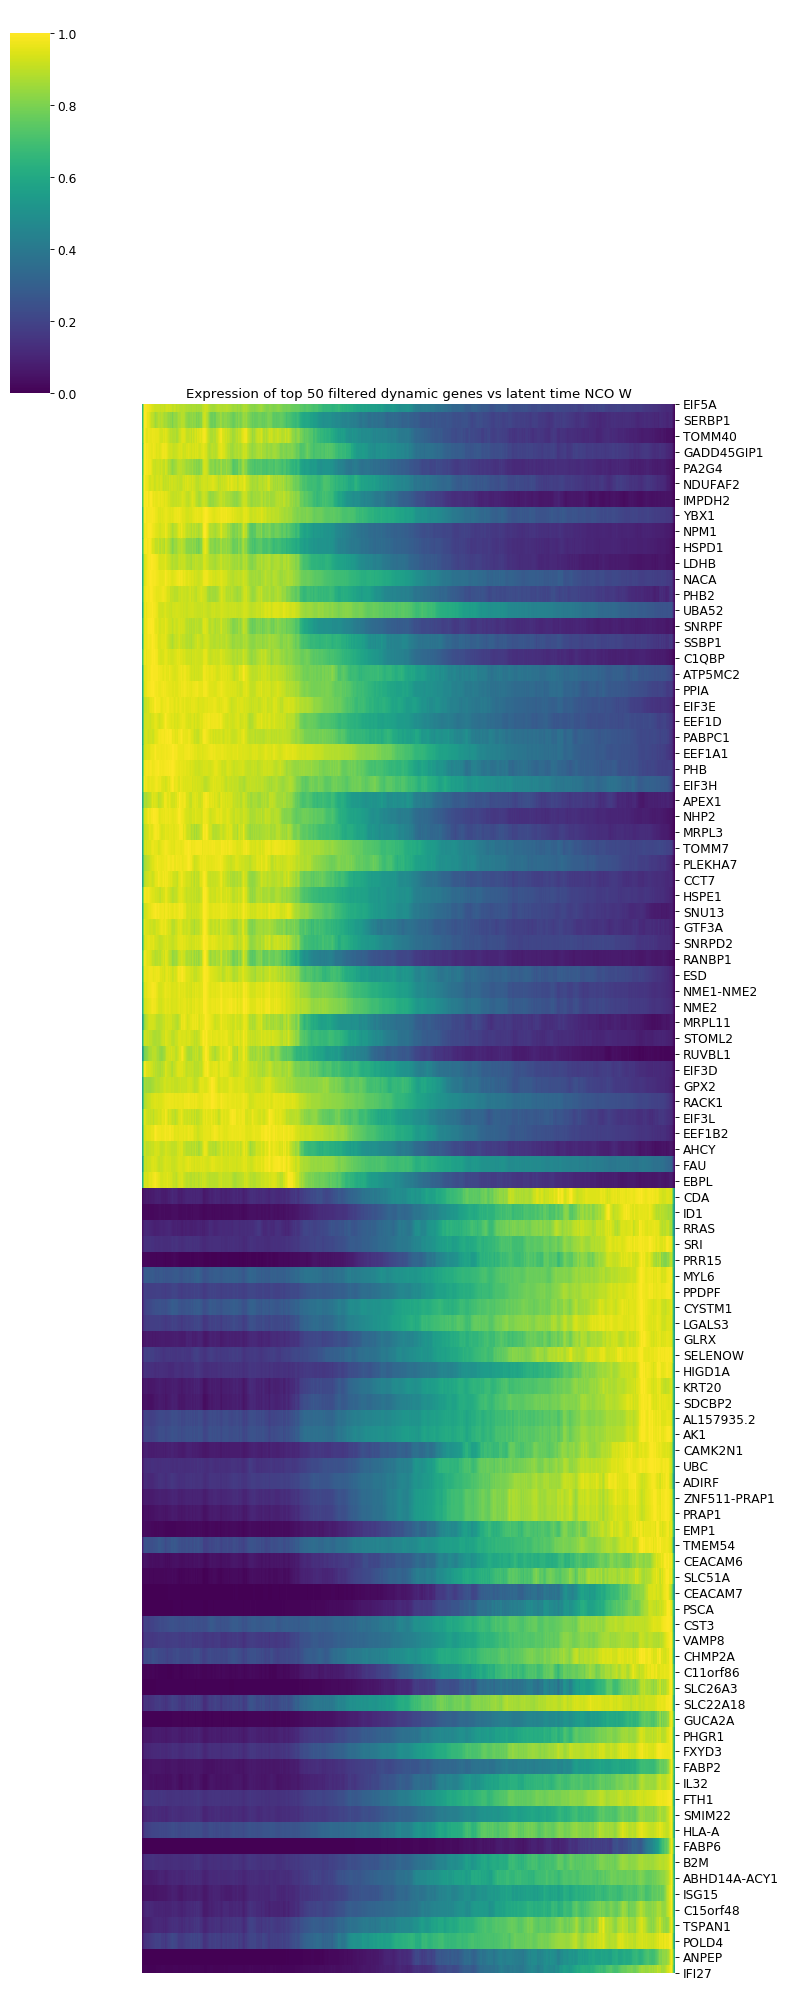

Index(['EIF5A', 'SERBP1', 'TOMM40', 'GADD45GIP1', 'PA2G4', 'NDUFAF2', 'IMPDH2',
       'YBX1', 'NPM1', 'HSPD1', 'LDHB', 'NACA', 'PHB2', 'UBA52', 'SNRPF',
       'SSBP1', 'C1QBP', 'ATP5MC2', 'PPIA', 'EIF3E', 'EEF1D', 'PABPC1',
       'EEF1A1', 'PHB', 'EIF3H', 'APEX1', 'NHP2', 'MRPL3', 'TOMM7', 'PLEKHA7',
       'CCT7', 'HSPE1', 'SNU13', 'GTF3A', 'SNRPD2', 'RANBP1', 'ESD',
       'NME1-NME2', 'NME2', 'MRPL11', 'STOML2', 'RUVBL1', 'EIF3D', 'GPX2',
       'RACK1', 'EIF3L', 'EEF1B2', 'AHCY', 'FAU', 'EBPL', 'CDA', 'ID1', 'RRAS',
       'SRI', 'PRR15', 'MYL6', 'PPDPF', 'CYSTM1', 'LGALS3', 'GLRX', 'SELENOW',
       'HIGD1A', 'KRT20', 'SDCBP2', 'AL157935.2', 'AK1', 'CAMK2N1', 'UBC',
       'ADIRF', 'ZNF511-PRAP1', 'PRAP1', 'EMP1', 'TMEM54', 'CEACAM6', 'SLC51A',
       'CEACAM7', 'PSCA', 'CST3', 'VAMP8', 'CHMP2A', 'C11orf86', 'SLC26A3',
       'SLC22A18', 'GUCA2A', 'PHGR1', 'FXYD3', 'FABP2', 'IL32', 'FTH1',
       'SMIM22', 'HLA-A', 'FABP6', 'B2M', 'ABHD14A-ACY1', 'ISG15', 'C15orf48',
       'TS

In [4]:
donor='NCO'
letter='W'

adata = scv.read(data_path+'NB_AS_'+letter+'/processed/NB_AS_'+letter+'_'+donor+'SLAMvelo.h5')

df = pd.read_csv('./exports/NB_AS_'+donor+letter+'_correlation_with_latenttime.csv', index_col=0)
mask=[d[0:2]!='RP' and d[0:3]!='MT-' for d in df.index]
df_ = df[mask]
var_names=list(df_.index[:50])+list(df_.index[-50:])

scv.tl.recover_latent_time(adata)
k=len(var_names)
print('...')
heatmap(adata, var_names=var_names, tkey='latent_time', figsize=(10,5*k/20), title='Expression of top 50 filtered dynamic genes vs latent time '+donor+' '+letter, colorbar=True, standard_scale=0)

In [5]:
name=[]
x=[]
thresh=0.55
for donor in ['NCO', 'p009ot', 'p013ot']:
    for letter in ['E', 'W']:
        df = pd.read_csv('./exports/NB_AS_'+donor+letter+'_correlation_with_latenttime.csv', index_col=0)
        mask=[d[0:2]!='RP' and d[0:3]!='MT-' for d in df.index]
        df_ = df[mask]
        var_names=list(df_[np.abs(df.spearmanr)>thresh].index)
        x.append(var_names)
        name.append(donor+letter)

In [6]:
from itertools import product
def n_tuples(sets):
    # give "sets" as a list of lists to return all possible tuples from
    return list(product(*sets))

In [7]:
from itertools import chain, combinations
def powerset(iterable, drop_empty=False):
    # adapted from Ran Feldesh on StackOverflow
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(int(drop_empty),len(s)+1)))

In [8]:
ps=powerset(np.arange(len(name)), drop_empty=True)
sets=np.array([set(y) for y in x])

In [9]:
intersets = []
names = []
for p in ps:    
    indices = np.array(p)
    names.append(np.array(name)[indices])
    if len(indices) > 0:
        intersets.append(sets[indices[0]].intersection(*sets[indices[1:]]))
    else:
        intersets.append(sets[indices])

In [12]:
df=pd.DataFrame([len(x) for x in intersets], index=[r' ∩ '.join(n) for n in names],columns=['size'])
df

,size
NCOE,31
NCOW,3999
p009otE,750
p009otW,846
p013otE,338
...,...
NCOE ∩ NCOW ∩ p009otE ∩ p013otE ∩ p013otW,1
NCOE ∩ NCOW ∩ p009otW ∩ p013otE ∩ p013otW,1
NCOE ∩ p009otE ∩ p009otW ∩ p013otE ∩ p013otW,1
NCOW ∩ p009otE ∩ p009otW ∩ p013otE ∩ p013otW,84


In [13]:
with_NCOW='NCOW ∩ p009otE ∩ p009otW ∩ p013otE ∩ p013otW'
ot_only='p009otE ∩ p009otW ∩ p013otE ∩ p013otW'
print(df[df.index==ot_only], df[df.index==with_NCOW])

                                       size
p009otE ∩ p009otW ∩ p013otE ∩ p013otW   109                                               size
NCOW ∩ p009otE ∩ p009otW ∩ p013otE ∩ p013otW    84


In [14]:
ot_ix = np.where(df.index==ot_only)[0][0]
NCOW_ix = np.where(df.index==with_NCOW)[0][0]

In [15]:
x=list(intersets[ot_ix])
total_df = None
for donor in ['p009ot', 'p013ot']:
    for letter in ['E', 'W']:
        df = pd.read_csv('./exports/NB_AS_'+donor+letter+'_correlation_with_latenttime.csv', index_col=0)
        idx=[np.where(df.index==y)[0][0] for y in x]
        df_=df.iloc[idx]
        df_.columns = df_.columns+'_'+donor+letter
        total_df = pd.concat([total_df, df_], axis=1) if total_df is not None else df_
total_df.to_csv('./exports/intersection_19_correlation_with_latenttime.csv')

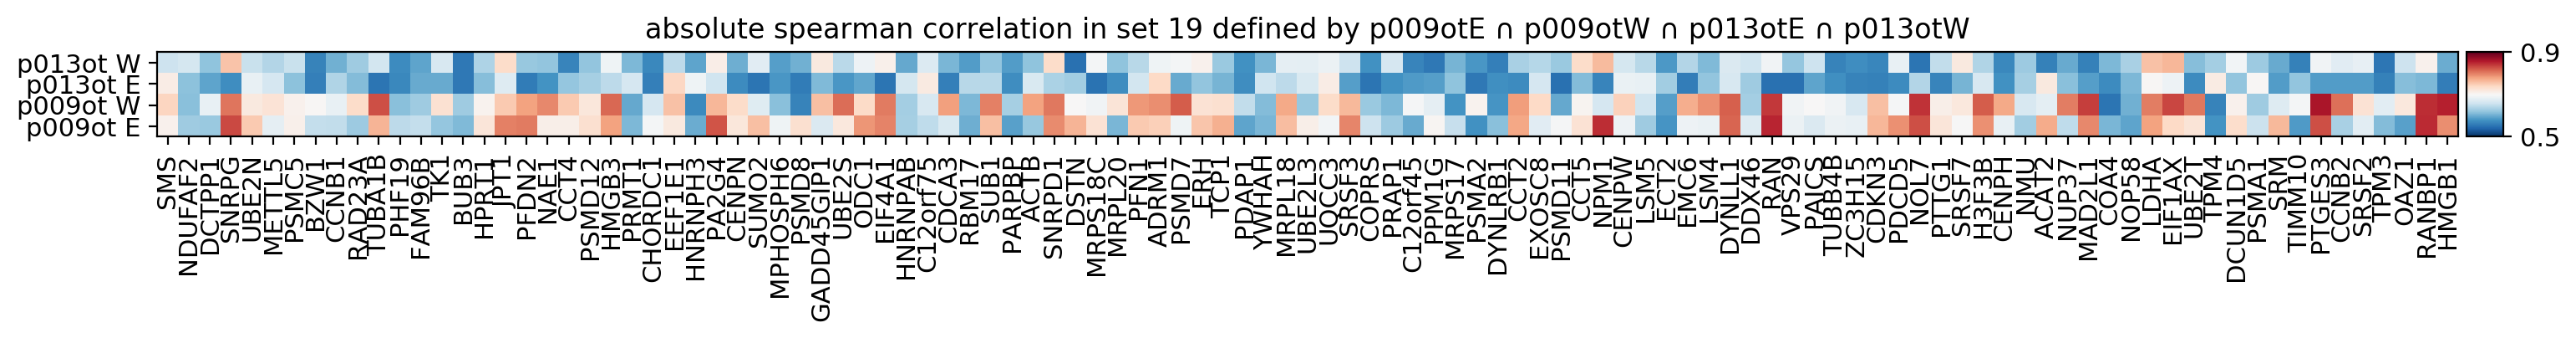

In [16]:
pl.figure(figsize=[18,8], dpi=100)
data=total_df.values.T[['spearmanr' in name for name in total_df.columns]]
im=pl.imshow(np.abs(data), vmax= .9, vmin=0.5)
pl.xticks(np.arange(len(total_df)),total_df.index, rotation=90);
pl.yticks(np.arange(4), [(' ').join(n) for n in n_tuples([['p009ot', 'p013ot'], ['E', 'W']])]);
pl.ylim([-0.5,3.5]);
pl.title('absolute spearman correlation in set 19 defined by '+ot_only);

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(pl.gca())
cax = divider.append_axes("right", size="1.6%", pad=0.05)
cbar = pl.colorbar(im, cax=cax);
cbar.set_clim(.5, .9)
cbar.set_ticks([.5,.9])

In [17]:
x=list(intersets[NCOW_ix])
total_df = None
for donor in ['p009ot', 'p013ot']:
    for letter in ['E', 'W']:
        df = pd.read_csv('./exports/NB_AS_'+donor+letter+'_correlation_with_latenttime.csv', index_col=0)
        idx=[np.where(df.index==y)[0][0] for y in x]
        df_=df.iloc[idx]
        df_.columns = df_.columns+'_'+donor+letter
        total_df = pd.concat([total_df, df_], axis=1) if total_df is not None else df_
        
donor='NCO'
letter='W'
df = pd.read_csv('./exports/NB_AS_'+donor+letter+'_correlation_with_latenttime.csv', index_col=0)
idx=[np.where(df.index==y)[0][0] for y in x]
df_=df.iloc[idx]
df_.columns = df_.columns+'_'+donor+letter
total_df = pd.concat([total_df, df_], axis=1) if total_df is not None else df_

total_df.to_csv('./exports/intersection_12_correlation_with_latenttime.csv')

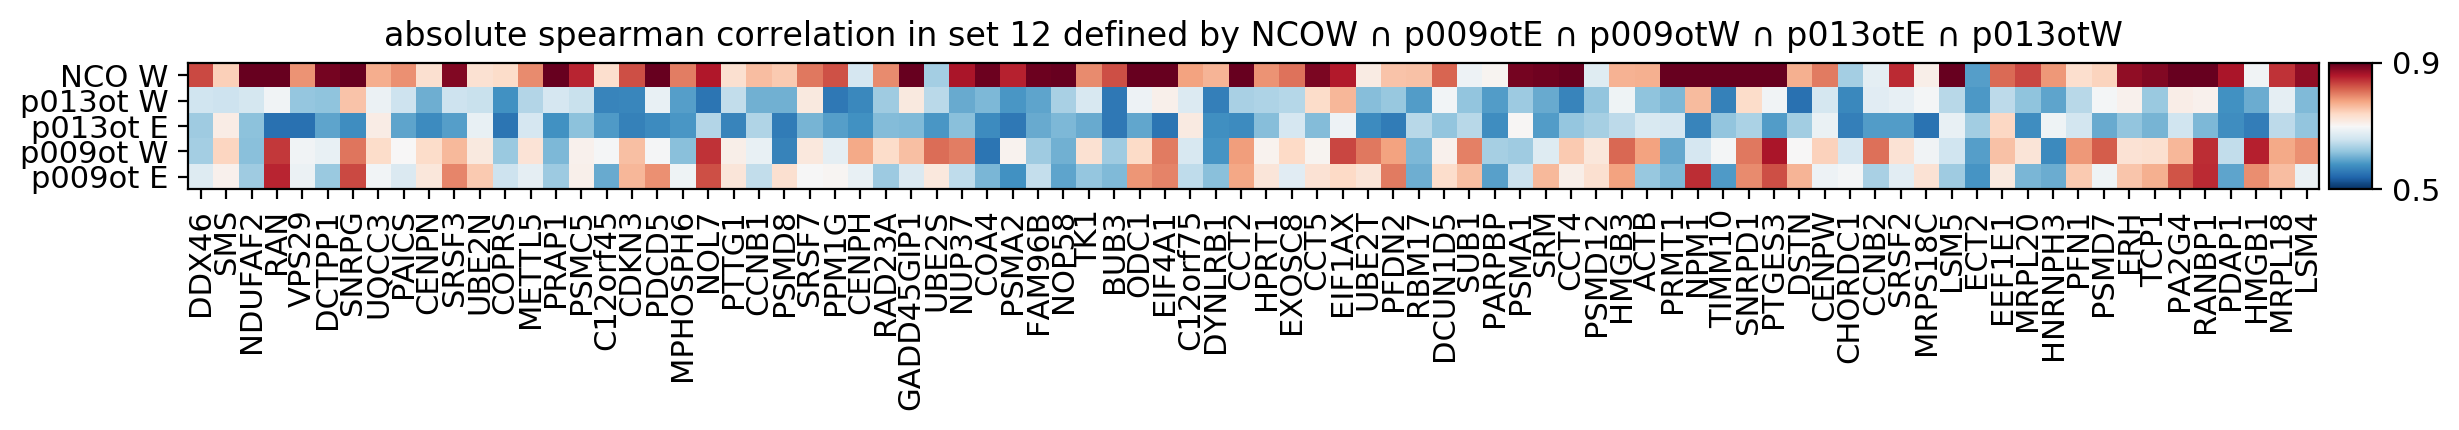

In [18]:
pl.figure(figsize=[14,8], dpi=100)
data=total_df.values.T[['spearmanr' in name for name in total_df.columns]]
im=pl.imshow(np.abs(data), vmax= .9, vmin=0.5)
pl.xticks(np.arange(len(total_df)),total_df.index, rotation=90);
pl.yticks(np.arange(5), [(' ').join(n) for n in n_tuples([['p009ot', 'p013ot'], ['E', 'W']])+[('NCO', 'W')]]);
pl.ylim([-0.5,4.5]);
pl.title('absolute spearman correlation in set 12 defined by '+with_NCOW);

from mpl_toolkits.axes_grid1 import make_axes_locatable
# create an axes on the right side of ax. The width of cax will be 2%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(pl.gca())
cax = divider.append_axes("right", size="2%", pad=0.05)
cbar = pl.colorbar(im, cax=cax);
cbar.set_clim(.5, .9)
cbar.set_ticks([.5,.9])

[False False False ... False False False]
[1772   46 1800 ... 1594 1639 1761]
...


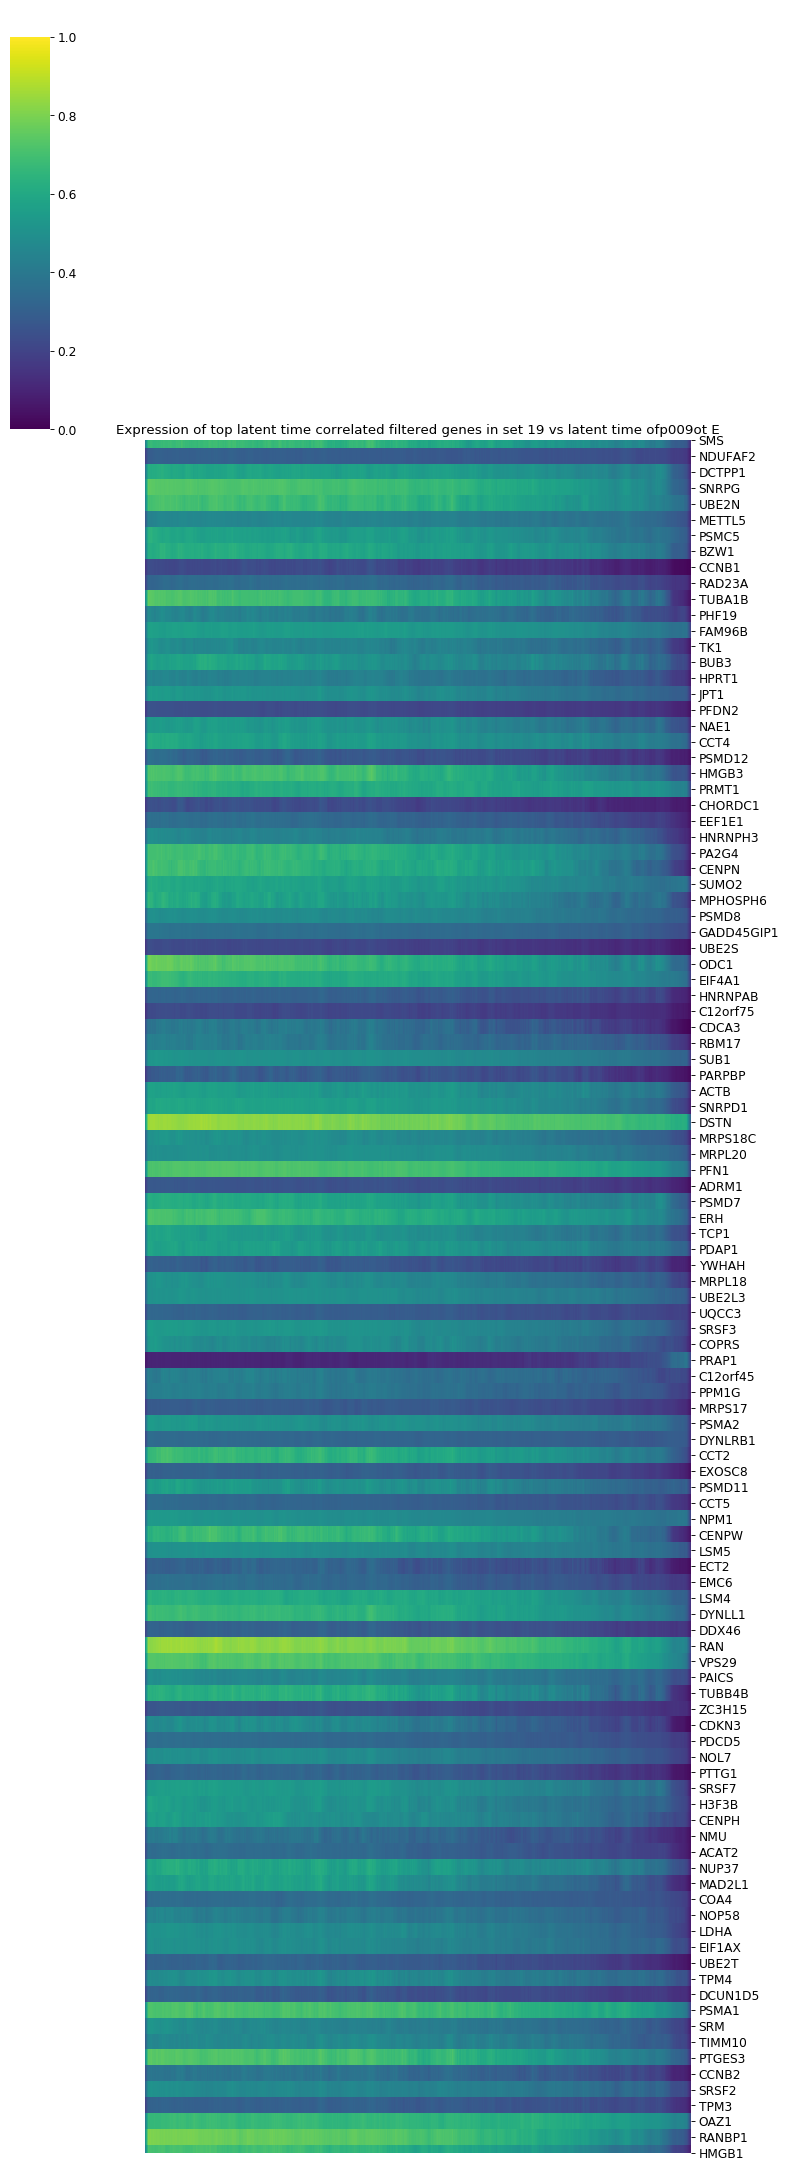

...


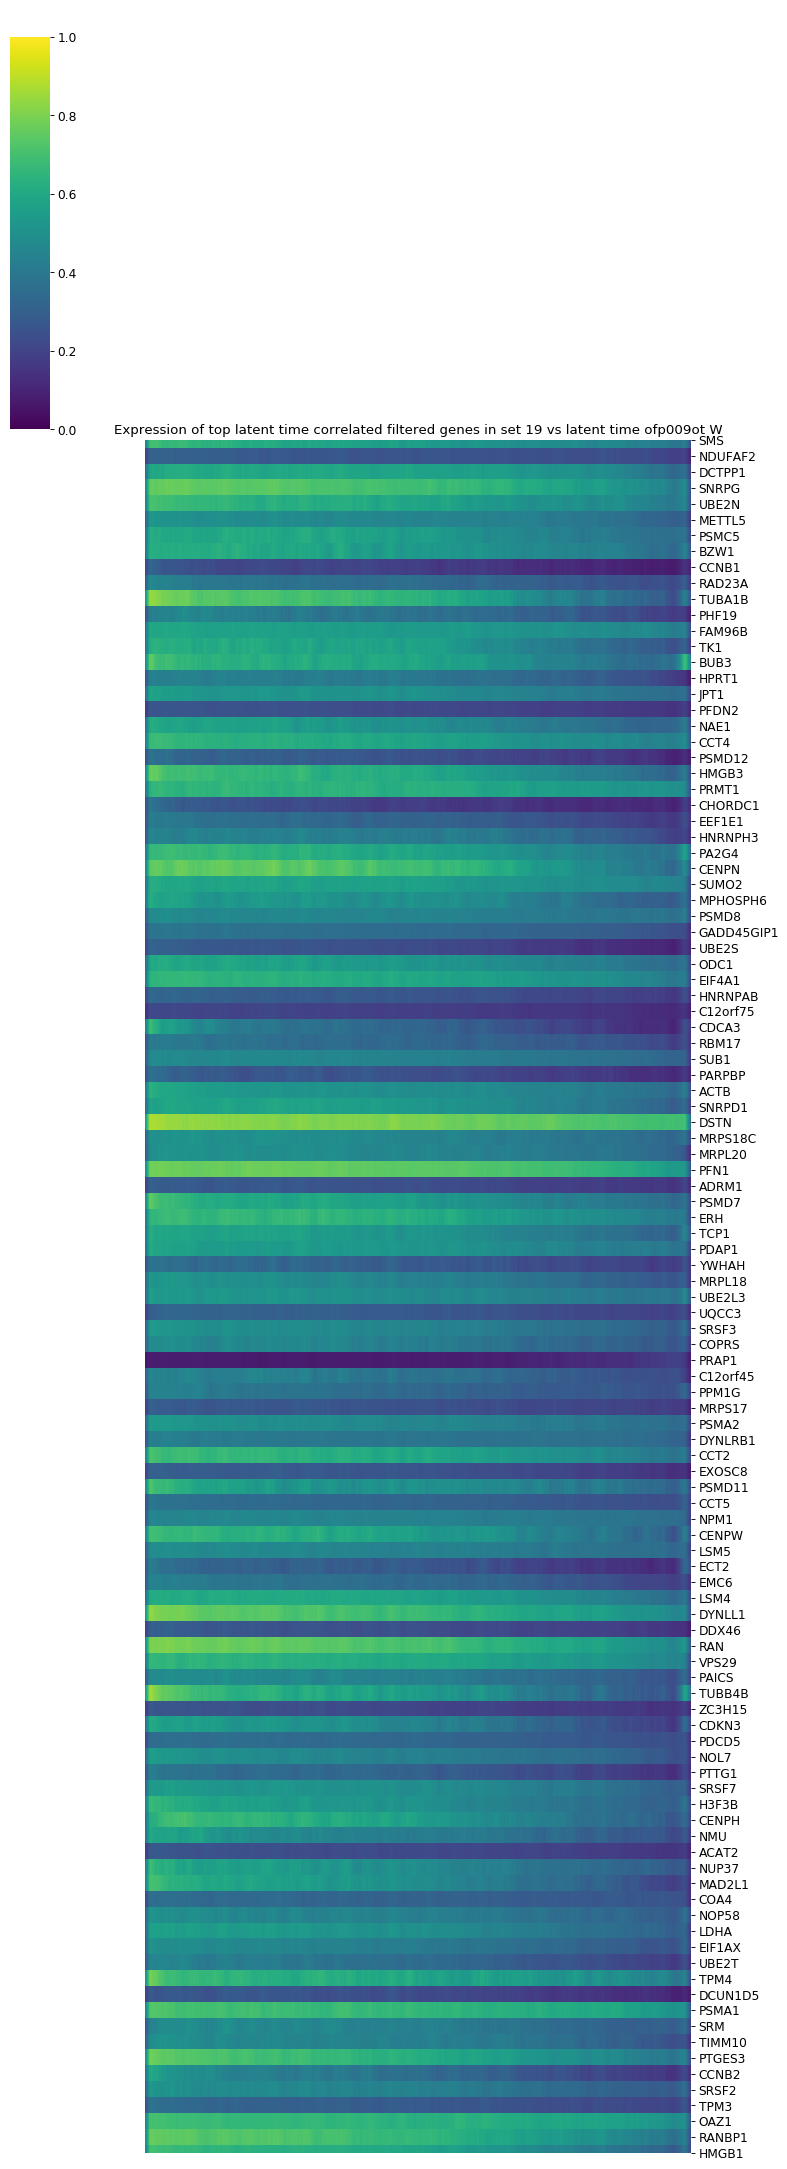

[False False False ... False False False]
[ 501  488  900 ...  977 1258  518]
...


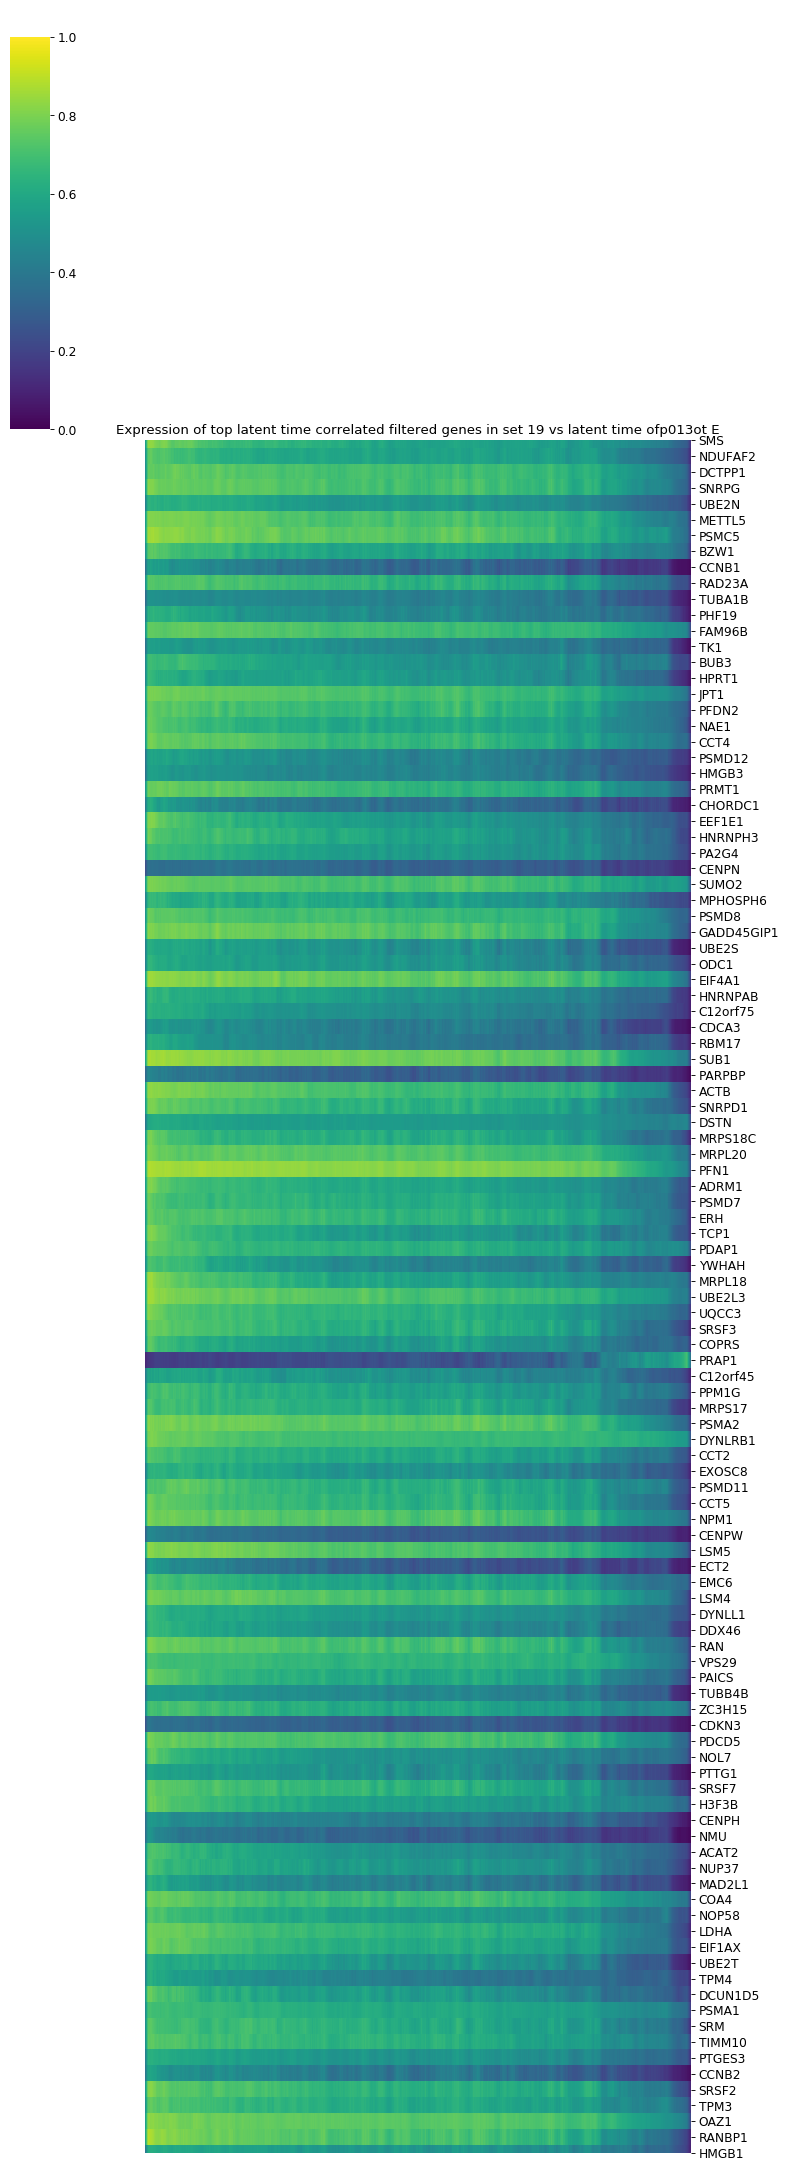

[False False False ... False False False]
[1530 1078 1511 ... 2781 2851 2435]
...


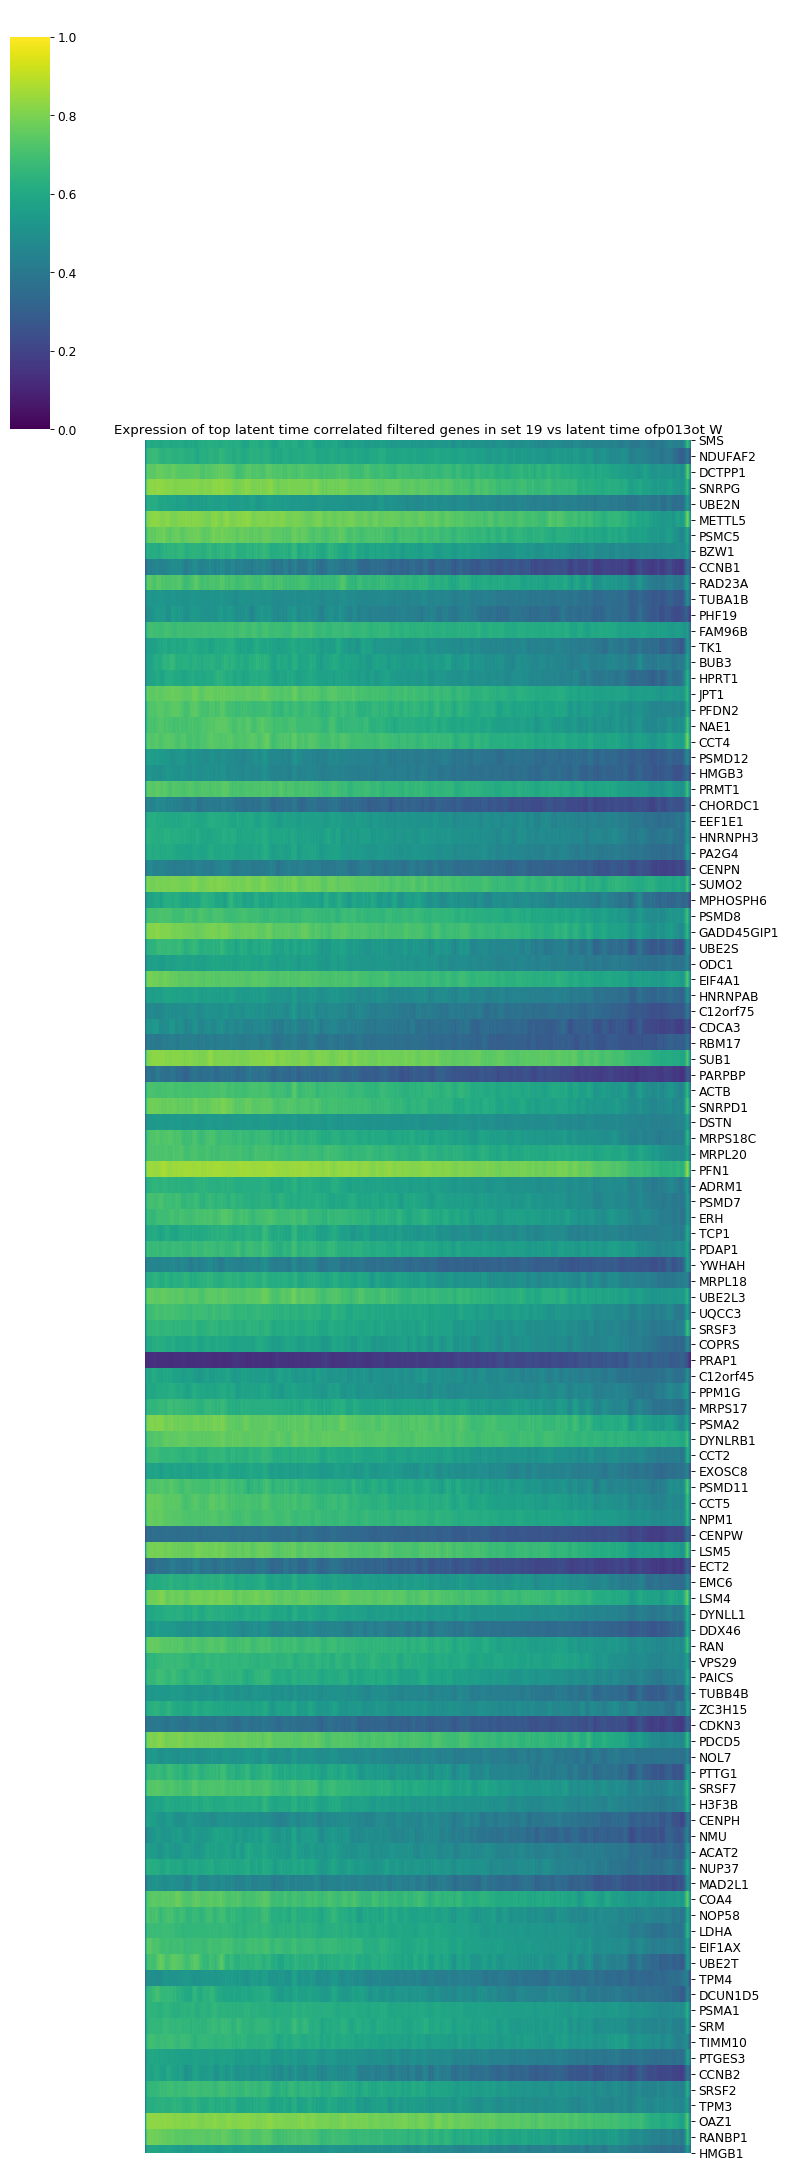

In [46]:
# Expression of top latent time correlated filtered genes in set 19 vs latent time of different models
# get expression maxima
maxi=[]
for donor in ['p009ot', 'p013ot']:
    for letter in ['E', 'W']:
        adata = scv.read(data_path+'NB_AS_'+letter+'/processed/NB_AS_'+letter+'_'+donor+'SLAMvelo.h5')
        var_names=list(intersets[ot_ix])
        var_names_ = [name for name in var_names if name in adata.var_names]
        maxis=np.max(adata[:,var_names_].layers['Ms'],axis=0)
        maxi.append(maxis)
maxis=np.max(maxi,axis=0)

for donor in ['p009ot', 'p013ot']:
    for letter in ['E', 'W']:
        adata = scv.read(data_path+'NB_AS_'+letter+'/processed/NB_AS_'+letter+'_'+donor+'SLAMvelo.h5')
        var_names=list(intersets[ot_ix])
        scv.tl.recover_latent_time(adata)
        k=len(var_names)
        print('...')
        heatmap(adata, var_names=var_names, tkey='latent_time', sort=False, figsize=(10,5*k/20), 
                title='Expression of top latent time correlated filtered genes in set 19 vs latent time of'+donor+' '+letter, colorbar=True, standard_scale=None,
                save='LTH_intersection19_'+donor+letter+'.png',
                maxis=maxis, vmin=0, vmax=1
               )

[False False False ... False False False]
[1772   46 1800 ... 1594 1639 1761]
...


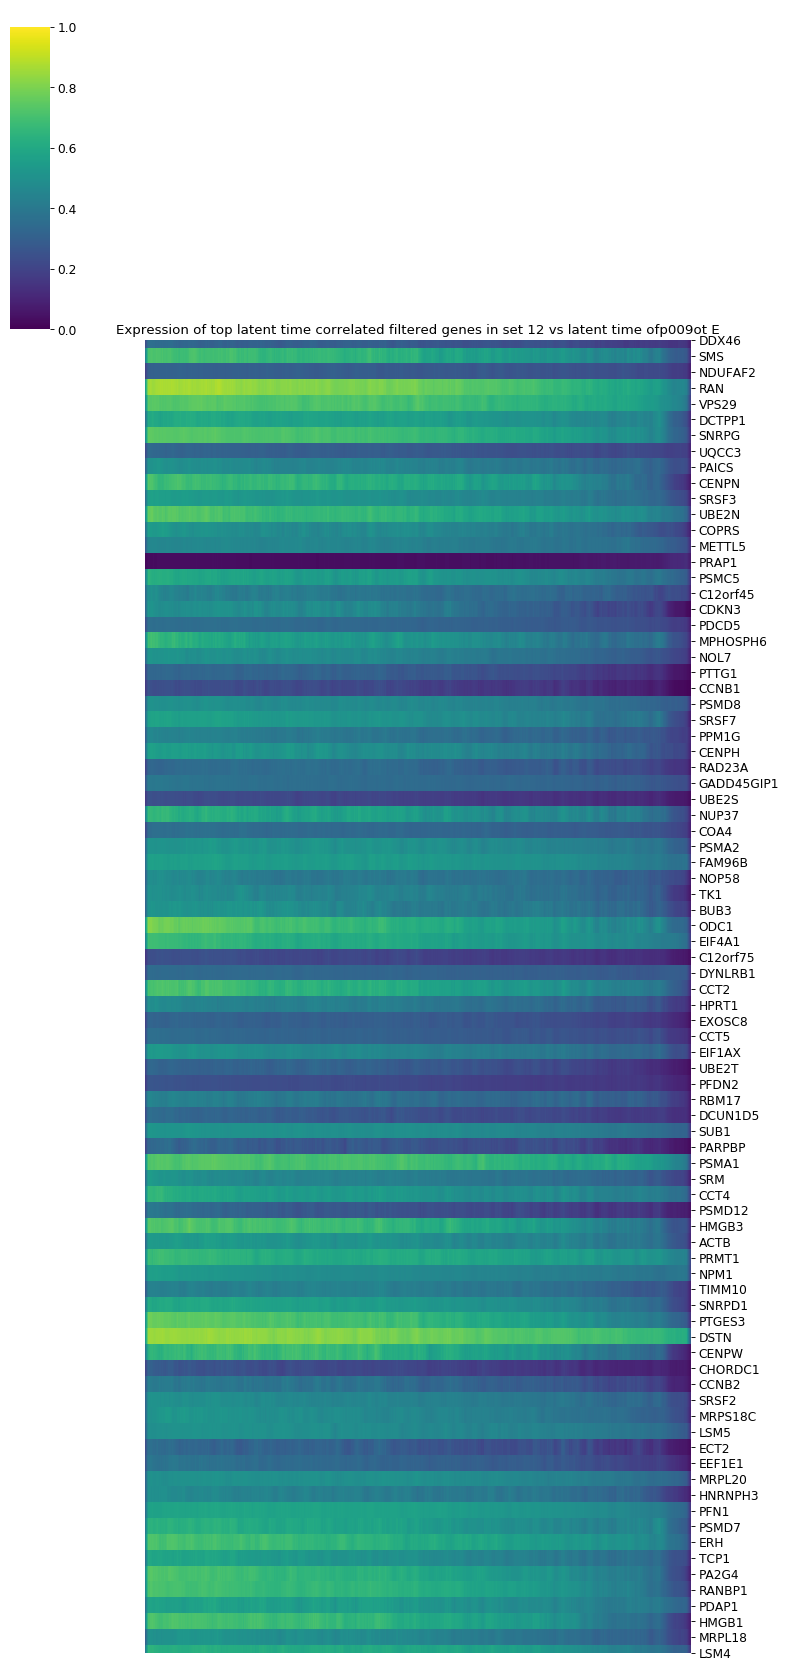

...


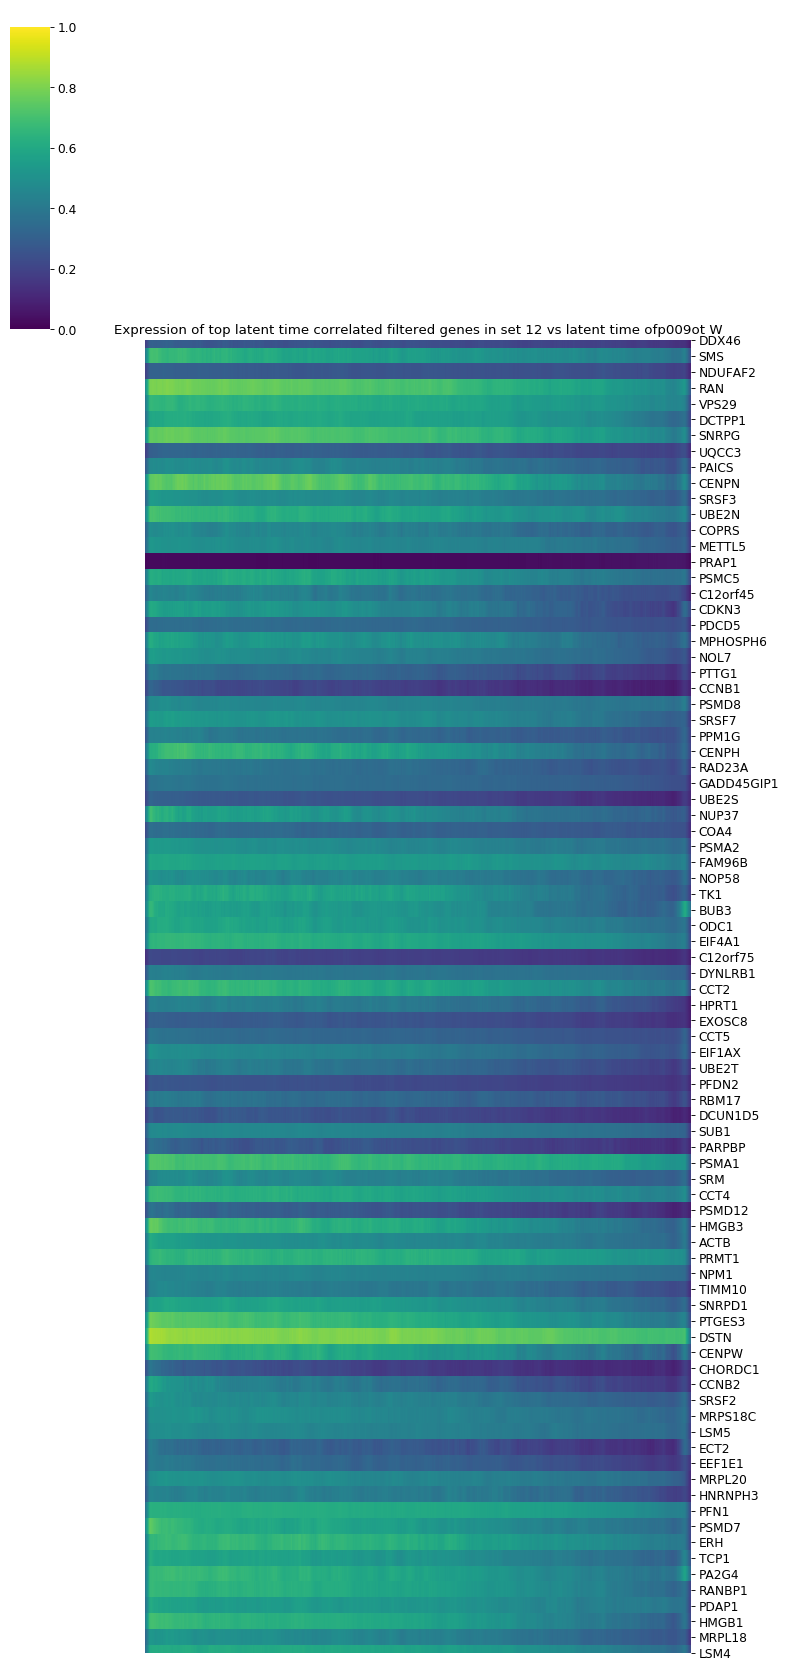

[False False False ... False False False]
[ 501  488  900 ...  977 1258  518]
...


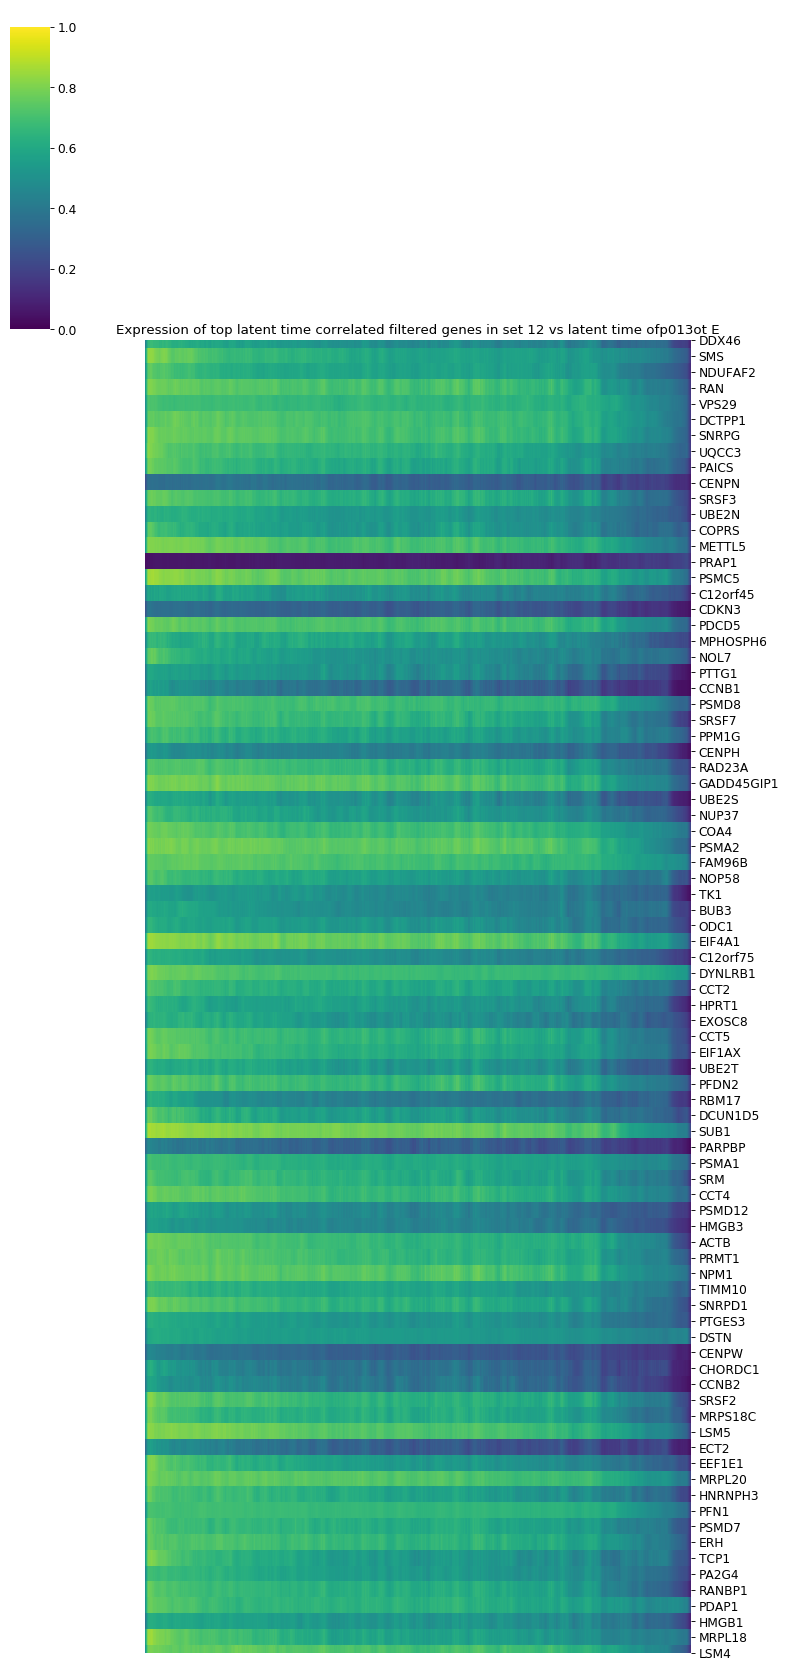

[False False False ... False False False]
[1530 1078 1511 ... 2781 2851 2435]
...


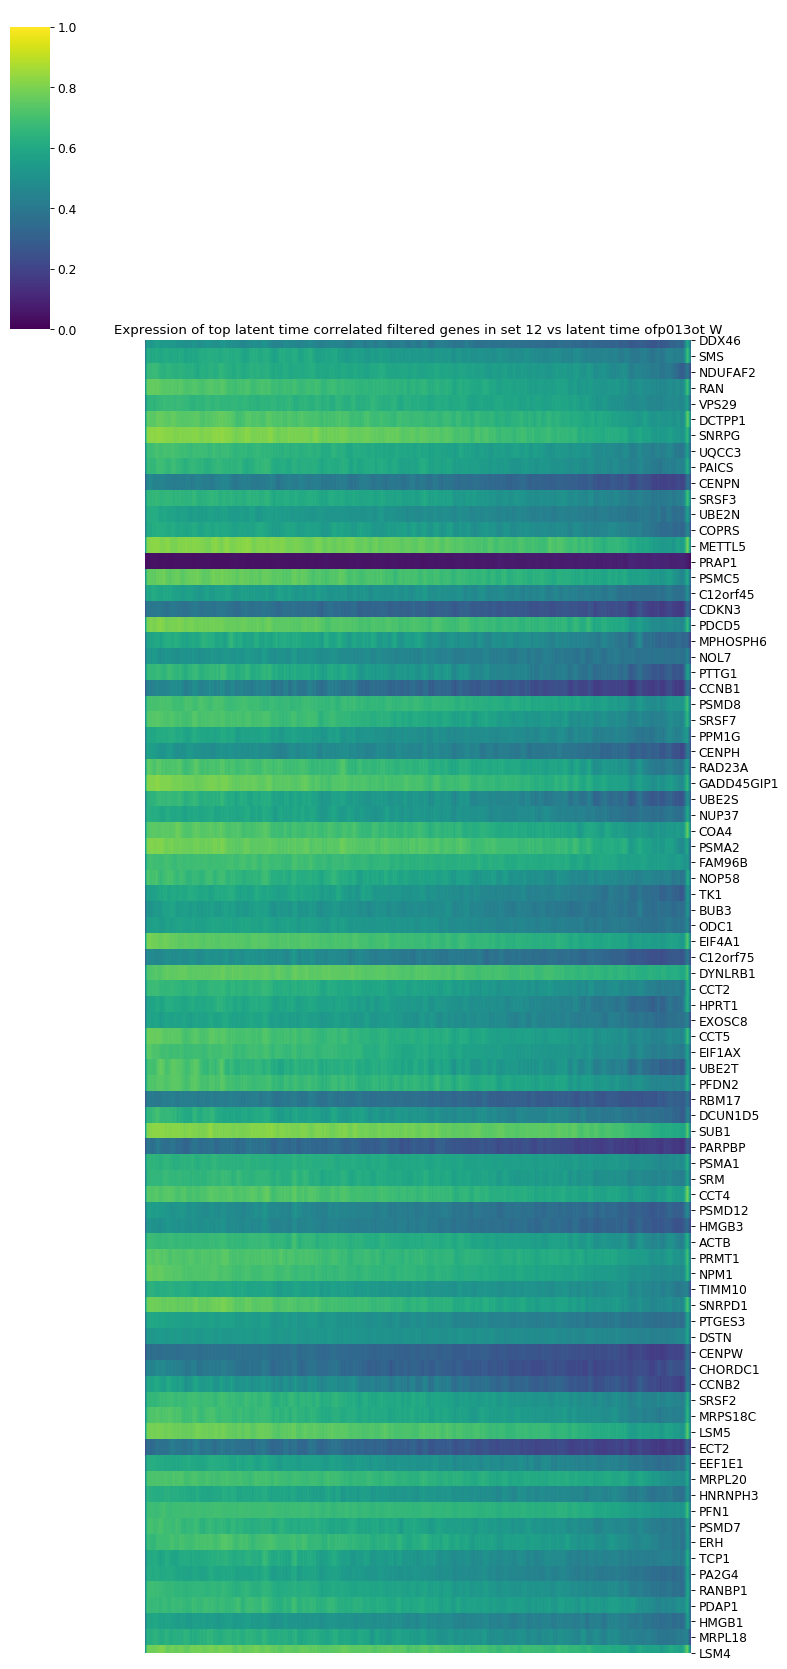

...


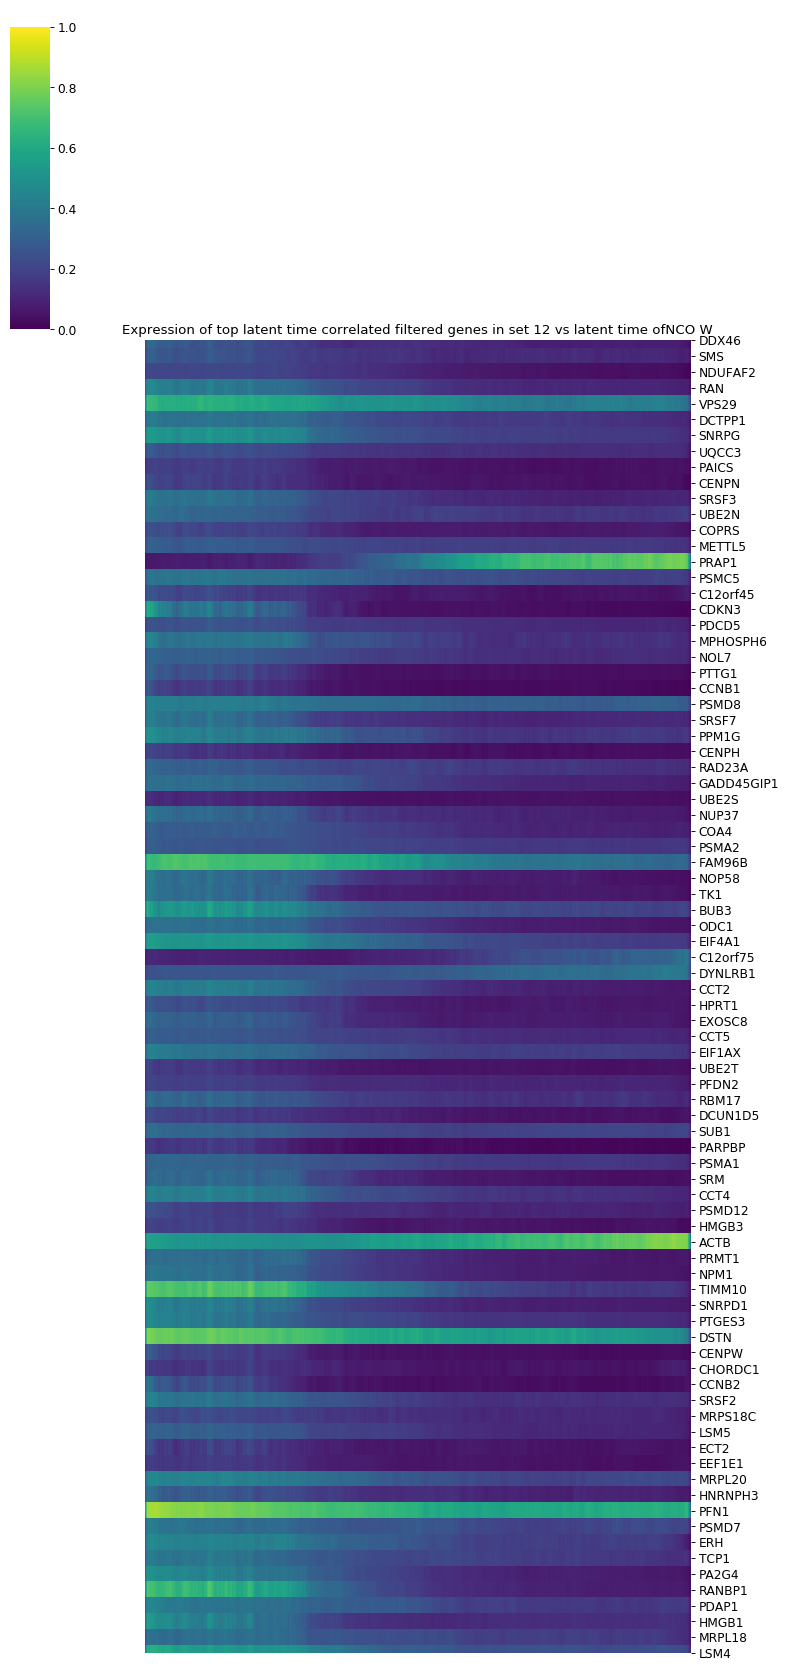

In [48]:
# Expression of top latent time correlated filtered genes in set 12 vs latent time of different models
# get expression maxima
maxi=[]
for donor in ['p009ot', 'p013ot']:
    for letter in ['E', 'W']:
        adata = scv.read(data_path+'NB_AS_'+letter+'/processed/NB_AS_'+letter+'_'+donor+'SLAMvelo.h5')
        var_names=list(intersets[NCOW_ix])
        var_names_ = [name for name in var_names if name in adata.var_names]
        maxis=np.max(adata[:,var_names_].layers['Ms'],axis=0)
        maxi.append(maxis)
for donor in ['NCO']:
    for letter in ['W']:
        adata = scv.read(data_path+'NB_AS_'+letter+'/processed/NB_AS_'+letter+'_'+donor+'SLAMvelo.h5')
        var_names=list(intersets[NCOW_ix])
        var_names_ = [name for name in var_names if name in adata.var_names]
        maxis=np.max(adata[:,var_names_].layers['Ms'],axis=0)
        maxi.append(maxis)
maxis=np.max(maxi,axis=0)

for donor in ['p009ot', 'p013ot']:
    for letter in ['E', 'W']:
        adata = scv.read(data_path+'NB_AS_'+letter+'/processed/NB_AS_'+letter+'_'+donor+'SLAMvelo.h5')
        var_names=list(intersets[NCOW_ix])
        scv.tl.recover_latent_time(adata)
        k=len(var_names)
        print('...')
        heatmap(adata, var_names=var_names, tkey='latent_time', sort=False, figsize=(10,5*k/20), 
                title='Expression of top latent time correlated filtered genes in set 12 vs latent time of'+donor+' '+letter, colorbar=True, standard_scale=None,
                save='LTH_intersection12_'+donor+letter+'.png',
                maxis=maxis, vmin=0, vmax=1
               )
for donor in ['NCO']:
    for letter in ['W']:
        adata = scv.read(data_path+'NB_AS_'+letter+'/processed/NB_AS_'+letter+'_'+donor+'SLAMvelo.h5')
        var_names=list(intersets[NCOW_ix])
        scv.tl.recover_latent_time(adata)
        k=len(var_names)
        print('...')
        heatmap(adata, var_names=var_names, tkey='latent_time', sort=False, figsize=(10,5*k/20), 
                title='Expression of top latent time correlated filtered genes in set 12 vs latent time of'+donor+' '+letter, colorbar=True, standard_scale=None,
                save='LTH_intersection12_'+donor+letter+'.png',
                maxis=maxis, vmin=0, vmax=1
               )

In [19]:
for donor in ['NCO']:
    for letter in ['W']:
        adata = scv.read(data_path+'NB_AS_'+letter+'/processed/NB_AS_'+letter+'_'+donor+'SLAMvelo.h5')
        scv.tl.recover_latent_time(adata)

In [20]:
var_names=list(intersets[ot_ix])
k=len(var_names)

...


[False False False ... False False False]
[1530 1078 1511 ... 2781 2851 2435]


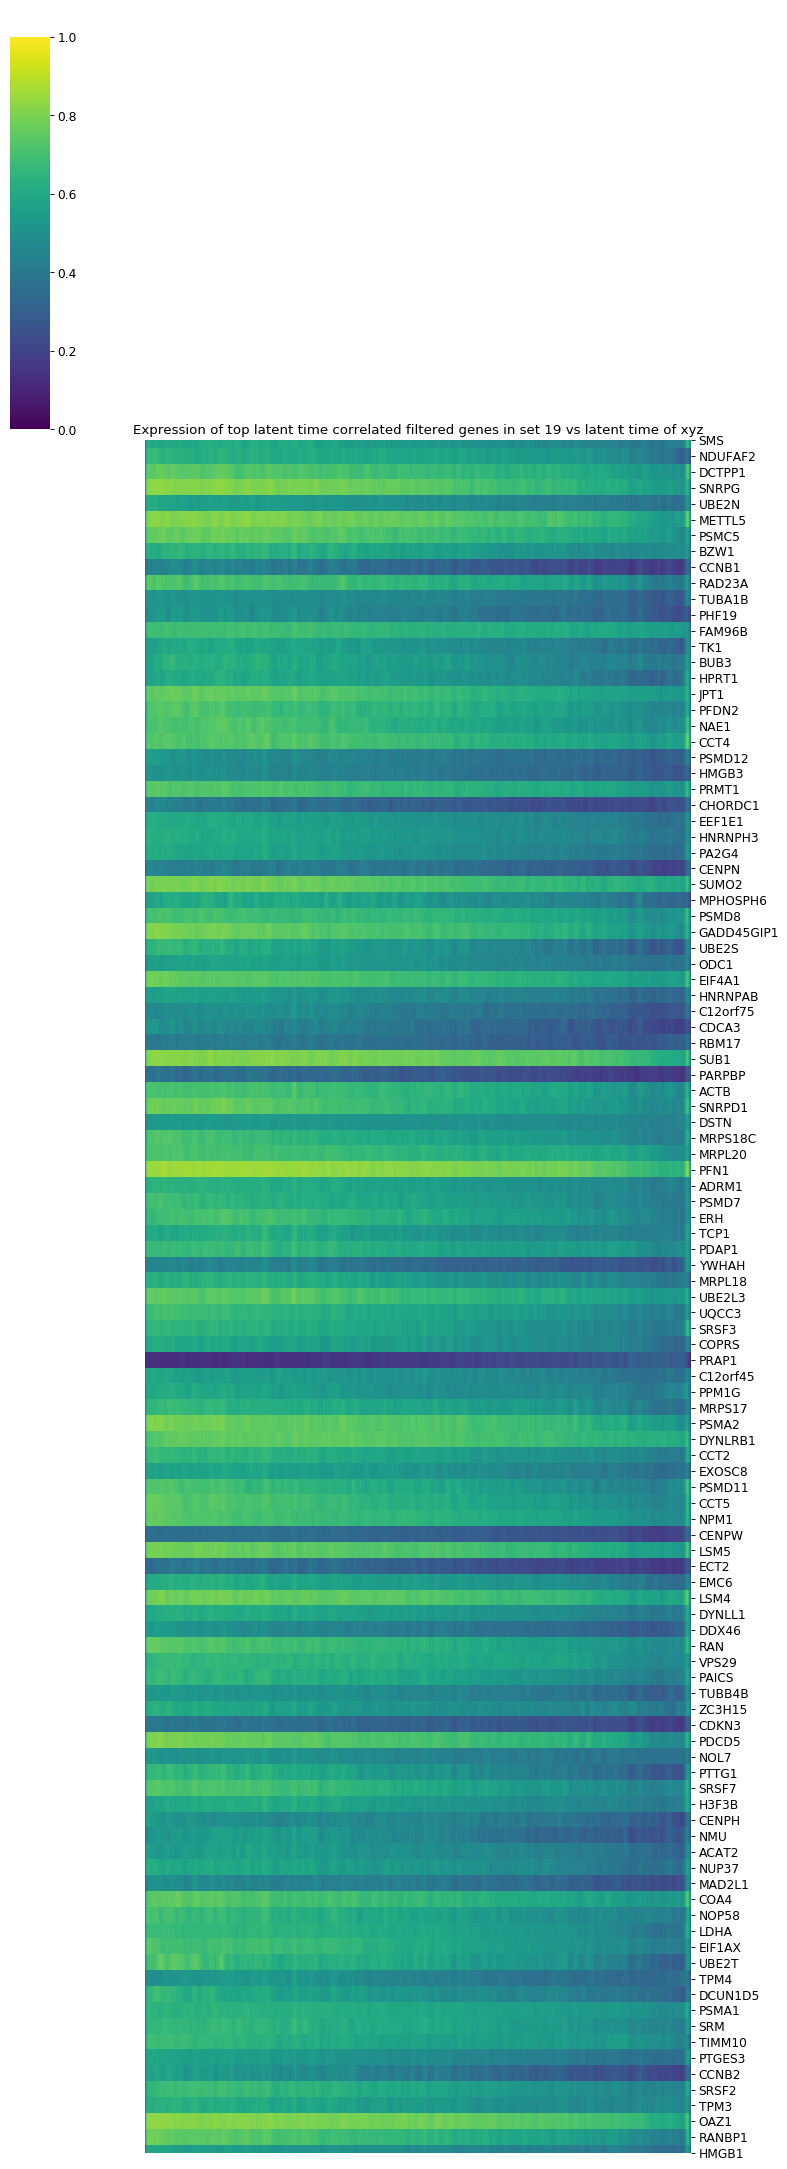

Index(['SMS', 'NDUFAF2', 'DCTPP1', 'SNRPG', 'UBE2N', 'METTL5', 'PSMC5', 'BZW1',
       'CCNB1', 'RAD23A',
       ...
       'PSMA1', 'SRM', 'TIMM10', 'PTGES3', 'CCNB2', 'SRSF2', 'TPM3', 'OAZ1',
       'RANBP1', 'HMGB1'],
      dtype='object', length=109)

In [42]:
scv.tl.recover_latent_time(adata)
k=len(var_names)
heatmap(adata, var_names=var_names, tkey='latent_time', sort=False, figsize=(10,5*k/20), 
        title='Expression of top latent time correlated filtered genes in set 19 vs latent time of xyz', colorbar=True, standard_scale=None,
        save='heloooo.png',
        maxis=maxis, vmin=0, vmax=1
       )

In [29]:
var_names_ = [name for name in var_names if name in adata.var_names]
np.max(adata[:,var_names_].layers['Ms'],axis=0)

ArrayView([ 1.7121983 ,  2.1172192 ,  3.1332285 , 14.22356   ,
            1.8046395 ,  2.4916952 ,  2.4862404 ,  4.246941  ,
            3.5249884 ,  1.8206582 , 18.545837  ,  0.5560407 ,
            7.1089106 ,  2.952381  ,  2.563654  ,  1.2826836 ,
           12.780819  ,  3.9514685 ,  1.303729  ,  3.8825316 ,
            0.99530256,  1.3262446 ,  2.8428936 ,  0.75268406,
            1.4221082 ,  1.4270768 ,  5.7337794 ,  0.90555775,
            5.873701  ,  0.90965486,  4.640926  ,  4.985937  ,
            4.1261573 ,  3.629466  ,  8.272097  ,  4.349993  ,
            4.4911027 ,  0.97415596,  1.4687304 ,  6.715372  ,
            0.4793695 , 46.153103  ,  6.3795667 ,  8.615775  ,
            1.7769791 ,  3.44831   , 25.577765  ,  3.3842852 ,
            2.2743928 ,  2.0328312 ,  3.9282687 ,  2.3059106 ,
            1.2136912 ,  2.2906911 ,  4.390718  ,  2.4168725 ,
            5.3085146 ,  1.1624967 , 49.329662  ,  0.9924737 ,
            2.5911212 ,  5.106427  ,  6.159566  ,  3.56